# Battle of the neighborhoods
#### 1. A description of the problem and a discussion of the background. (15 marks)


The problem is to provide information to someone to help with a decision of where to move within the US. The scope will be the top 100 cities in the US by population. If the person who is moving has an idea of a city they like, for example, a city like Minneapolis, and wants to know other cities like that one, a cluster analysis could help identify the other similar cities within the same cluster as Minneapolis. Conversely, if the person moving knows they do NOT like Minneapolis, they could avoid moving to cities within the same cluster as it.

#### 2. A description of the data and how it will be used to solve the problem. (15 marks)

I will use data from wikipedia to provide list of the top 100 cities, including location (latitude and longitude), population, land area, population density, and growth rate. This data will have to be manipulated and cleaned up, extra characters removed, and converted to numeric data. I will also plot the 100 city locations on a US map.

To this data, I will add additional data from Foursquare about the venues in each city. The venue categories will be the main point of comparison, specifically, the percent breakdown of each type of venue category. To do this, I'll have to convert the categories into dummies first.

With the completed data set, I will normalize all the columns of the dataframe (population, area, growth, density, venue categories) for preparation into cluster analysis. I will run a few different cluster models and evaluate performance of these. Finally, I will provide the cluster results of similar cities, as well as an updated color-coded map.

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [203]:
import requests
import pandas as pd
import types
import numpy as np
from botocore.client import Config
import ibm_boto3
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

try:
    import folium
except:
    !conda install -c conda-forge folium=0.5.0 --yes
    import folium

#### Start by scraping Wikipedia page and limit to top 100

In [2]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population', header=0)

In [15]:
df = tables[4]
# Limit to top 100 cities
df = df[:100]

#### Parse the latitude and longitude values, and add as new df columns. Drop the unnecessary columns.

In [16]:
latlon = df.Location.str.split('\ufeff / \ufeff')
latlon = [i[1].split(' ') for i in latlon]
lat = [float(i[0][:-2]) for i in latlon]
lon = [-float(i[1][:-2]) for i in latlon]

In [18]:
df['Latitude'] = lat
df['Longitude'] = lon
df = df.drop(['Location','2010Census','2016 land area.1','2016 population density.1','2019rank'], axis=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
df.head(20)

,City,State,Population,% Change,Area sqmi,Pop density p/sqmi,Latitude,Longitude
0,New York[d],New York,8336817,+1.98%,301.5 sq mi,"28,317/sq mi",40.6635,-73.9387
1,Los Angeles,California,3979576,+4.93%,468.7 sq mi,"8,484/sq mi",34.0194,-118.4108
2,Chicago,Illinois,2693976,−0.06%,227.3 sq mi,"11,900/sq mi",41.8376,-87.6818
3,Houston[3],Texas,2320268,+10.48%,637.5 sq mi,"3,613/sq mi",29.7866,-95.3909
4,Phoenix,Arizona,1680992,+16.28%,517.6 sq mi,"3,120/sq mi",33.5722,-112.0901
5,Philadelphia[e],Pennsylvania,1584064,+3.80%,134.2 sq mi,"11,683/sq mi",40.0094,-75.1333
6,San Antonio,Texas,1547253,+16.56%,461.0 sq mi,"3,238/sq mi",29.4724,-98.5251
7,San Diego,California,1423851,+8.91%,325.2 sq mi,"4,325/sq mi",32.8153,-117.1350
8,Dallas,Texas,1343573,+12.17%,340.9 sq mi,"3,866/sq mi",32.7933,-96.7665
9,San Jose,California,1021795,+8.02%,177.5 sq mi,"5,777/sq mi",37.2967,-121.8189


#### Rename columns, clean up misc characters, and convert to floats

In [22]:
df = df.rename(columns={"State[c]": "State", "2019estimate": "Population",\
                   "Change" : "% Change", "2016 land area" : "Area sqmi",\
                   "2016 population density" : "Pop density p/sqmi"})

In [ ]:
# There is a funny character that looks like a '-' but is actually a '−'. Side-by-side: −-
df["% Change"] = df["% Change"].str.rstrip('%').str.lstrip('+').str.replace('−','-').astype(float)


In [76]:
df['Area sqmi'] = df['Area sqmi'].str[:-6].replace(',','', regex=True).astype(float)

In [83]:
df['Pop density p/sqmi'] = df['Pop density p/sqmi'].str.strip('/sq\xa0mi').replace(',','', regex=True).astype(float)

In [90]:
print(df.head())
print(df.shape)

          City       State  Population  % Change  Area sqmi  \
0  New York[d]    New York     8336817      1.98      301.5   
1  Los Angeles  California     3979576      4.93      468.7   
2      Chicago    Illinois     2693976     -0.06      227.3   
3   Houston[3]       Texas     2320268     10.48      637.5   
4      Phoenix     Arizona     1680992     16.28      517.6   

   Pop density p/sqmi  Latitude  Longitude  
0             28317.0   40.6635   -73.9387  
1              8484.0   34.0194  -118.4108  
2             11900.0   41.8376   -87.6818  
3              3613.0   29.7866   -95.3909  
4              3120.0   33.5722  -112.0901  
(100, 8)


#### Map of top 100 cities

In [94]:
#Looked these up from Google
us_lat = 37.0902
us_long = -95.7129

# create map
map_us = folium.Map(location=[us_lat, us_long], zoom_start=3)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
    
map_us

#### Foursquare parameters

In [232]:
VERSION = '20200430' # Foursquare API version
LIMIT = 2000

#### Foursquare credentials (hidden)

In [96]:
# The code was removed by Watson Studio for sharing.

#### Create function to get nearby venues

In [233]:
def getNearbyVenues(names, latitudes, longitudes, radius=32000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [234]:
us_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])
us_venues.head()

New York[d]
Los Angeles
Chicago
Houston[3]
Phoenix
Philadelphia[e]
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville[f]
Fort Worth
Columbus
Charlotte
San Francisco[g]
Indianapolis[h]
Seattle
Denver[i]
Washington[j]
Boston
El Paso
Nashville[k]
Detroit
Oklahoma City
Portland
Las Vegas
Memphis
Louisville[l]
Baltimore[m]
Milwaukee
Albuquerque
Tucson
Fresno
Mesa
Sacramento
Atlanta
Kansas City
Colorado Springs
Omaha
Raleigh
Miami
Long Beach
Virginia Beach[m]
Oakland
Minneapolis
Tulsa
Tampa
Arlington
New Orleans[n]
Wichita
Bakersfield
Cleveland
Aurora
Anaheim
Honolulu[b]
Santa Ana
Riverside
Corpus Christi
Lexington[o]
Henderson
Stockton
Saint Paul
Cincinnati
St. Louis[m]
Pittsburgh
Greensboro
Lincoln
Anchorage[p]
Plano
Orlando
Irvine
Newark
Durham
Chula Vista
Toledo
Fort Wayne
St. Petersburg
Laredo
Jersey City
Chandler
Madison
Lubbock
Scottsdale
Reno
Buffalo
Gilbert[q]
Glendale
North Las Vegas
Winston–Salem
Chesapeake[m]
Norfolk[m]
Fremont
Garland
Irving
Hialeah
Richmond[m]
Boise[r]
S

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York[d],40.6635,-73.9387,Brooklyn Botanic Garden,40.667622,-73.963191,Botanical Garden
1,New York[d],40.6635,-73.9387,Covenhoven,40.675143,-73.960203,Beer Bar
2,New York[d],40.6635,-73.9387,Brooklyn Museum,40.671521,-73.963677,Art Museum
3,New York[d],40.6635,-73.9387,Kings Theatre,40.646110,-73.957175,Theater
4,New York[d],40.6635,-73.9387,Prospect Park Boathouse & Audubon Center,40.660884,-73.964949,Building


#### Cool, the Foursquare call worked. It was a big one. Let's see how many results there were.

In [235]:
us_venues.shape

(9907, 7)

#### Get all venue categories from Foursquare so groups can be combined

In [236]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION)
categories = requests.get(url).json()['response']['categories']

#### Now let's look at a partial summary of the venues and their counts

In [237]:
us_venues.groupby('Venue Category').count()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Accessories Store,3,3,3,3,3,3
Adult Boutique,2,2,2,2,2,2
Afghan Restaurant,1,1,1,1,1,1
African Restaurant,1,1,1,1,1,1
Airport,1,1,1,1,1,1
Airport Lounge,3,3,3,3,3,3
American Restaurant,260,260,260,260,260,260
Amphitheater,4,4,4,4,4,4
Antique Shop,3,3,3,3,3,3


#### Convert this venue list to dummies so we can start dealing with numbers

In [238]:
# one hot encoding
us_onehot = pd.get_dummies(us_venues[['Venue Category']], prefix="", prefix_sep="")

#Drop Neighborhood column
us_onehot = us_onehot.drop(columns=['Neighborhood'], axis=1)


In [239]:
# add City column back to dataframe
us_onehot['City'] = us_venues['City'] 

# move City column to the first column
fixed_columns = [us_onehot.columns[-1]] + list(us_onehot.columns[:-1])
us_onehot = us_onehot[fixed_columns]

us_onehot.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,New York[d],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York[d],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York[d],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York[d],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York[d],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
us_onehot.shape

(9907, 371)

#### Now group the dummy sums by City to get the number of rows back to the 100 cities

In [241]:
us_grouped = us_onehot.groupby('City').sum()
us_grouped

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
City,,,,,,,,,,,,,,,,,,,,,
Albuquerque,0,0,0,0,0,0,3,0,0,0,...,0,0,0,2,0,0,0,1,1,0
Anaheim,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
Anchorage[p],0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,0,0,0,1,2,0,0,0,...,0,0,0,1,0,1,0,0,1,0
Atlanta,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
Aurora,0,0,0,0,0,0,2,0,0,0,...,0,0,0,2,0,0,1,1,1,0
Austin,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,0
Bakersfield,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Baltimore[m],0,0,1,0,0,0,1,0,0,1,...,0,0,0,3,0,0,0,0,0,0


In [242]:
us_grouped.shape

(100, 370)

In [243]:
df_full = df.sort_values(['City']).set_index('City')

In [244]:
df_full.head()

,State,Population,% Change,Area sqmi,Pop density p/sqmi,Latitude,Longitude
City,,,,,,,
Albuquerque,New Mexico,560513,2.69,188.2,2972.0,35.1056,-106.6474
Anaheim,California,350365,4.19,50.0,7021.0,33.8555,-117.7601
Anchorage[p],Alaska,288000,-1.31,1706.6,175.0,61.1743,-149.2843
Arlington,Texas,398854,9.14,95.8,4100.0,32.7007,-97.1247
Atlanta,Georgia,506811,20.67,133.5,3539.0,33.7629,-84.4227


#### Time to add the two dataframes together. Since both are sorted alphabetically by citiy, this should be pretty straightforward

In [245]:
df_full = df_full.join(us_grouped)
df_full.head()

,State,Population,% Change,Area sqmi,Pop density p/sqmi,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
City,,,,,,,,,,,,,,,,,,,,,
Albuquerque,New Mexico,560513,2.69,188.2,2972.0,35.1056,-106.6474,0,0,0,...,0,0,0,2,0,0,0,1,1,0
Anaheim,California,350365,4.19,50.0,7021.0,33.8555,-117.7601,0,0,0,...,0,0,0,0,0,0,0,2,0,0
Anchorage[p],Alaska,288000,-1.31,1706.6,175.0,61.1743,-149.2843,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington,Texas,398854,9.14,95.8,4100.0,32.7007,-97.1247,0,0,0,...,0,0,0,1,0,1,0,0,1,0
Atlanta,Georgia,506811,20.67,133.5,3539.0,33.7629,-84.4227,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Cluster analysis time. Drop state name. Scale using MinMaxScaler to avoid distortion from outliers. 

In [277]:
clusterdata = df_full.drop(['State'], axis=1)
clusterdata = MinMaxScaler().fit_transform(clusterdata)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Then run KMeans with a range of parameters to visualize the "elbow" in the curve

In [278]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(clusterdata)
    Sum_of_squared_distances.append(km.inertia_)

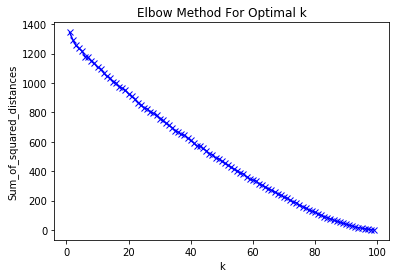

In [279]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Well.... that was not expected. I was hoping to see an "elbow", and instead got a "straight arm"...

#### 100 clusters for 100 cities is ridiculous. 10 feels right, but is somewhat arbitrary

In [280]:
kclusters = 10
km = KMeans(n_clusters=kclusters, random_state=0).fit(clusterdata)
df_full['Labels'] = km.labels_

#### Now to map the cities and color them by cluster

In [281]:
# create map
us_lat = 37.0902
us_long = -95.7129
us_labeled = folium.Map(location=[us_lat, us_long], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_full['Latitude'], df_full['Longitude'], df_full.index, df_full['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(us_labeled)
       
us_labeled

In [282]:
for k in range(0,kclusters):
    print("Cities in cluster {}: {}".format(k, ', '.join(df_full[df_full.Labels==k].index.tolist())))

Cities in cluster 0: Chesapeake[m], Corpus Christi, Virginia Beach[m]
Cities in cluster 1: Fremont, San Jose
Cities in cluster 2: Albuquerque, Baltimore[m], Boston, Charlotte, Chicago, Cincinnati, Cleveland, Denver[i], Detroit, Indianapolis[h], Irving, Kansas City, Louisville[l], Madison, Memphis, Milwaukee, Nashville[k], New Orleans[n], Philadelphia[e], Pittsburgh, Sacramento, St. Louis[m], Tampa, Tulsa, Washington[j], Wichita
Cities in cluster 3: Atlanta, Austin, Baton Rouge[s], Boise[r], Chula Vista, Dallas, Garland, Glendale, Henderson, Honolulu[b], Houston[3], Jacksonville[f], Los Angeles, North Las Vegas, Oakland, Phoenix, Plano, Portland, Richmond[m], Scottsdale, St. Petersburg, Tucson
Cities in cluster 4: Jersey City, New York[d], Newark
Cities in cluster 5: Anchorage[p], Chandler, El Paso, Fort Wayne, Gilbert[q], Mesa, Toledo
Cities in cluster 6: Anaheim, Arlington, Aurora, Bakersfield, Buffalo, Colorado Springs, Durham, Fort Worth, Fresno, Irvine, Laredo, Lincoln, Long Beach,